# Host-guest usage with stk

by: Andrew Tarzia

# Imports 

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem 
from rdkit.Chem import AllChem as rdkit
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
from IPython.display import Image
import matplotlib.pyplot as plt
import subprocess
import time
import stk
import stko
import spindry as spd
%matplotlib inline

# Some useful functions 

In [2]:
def show_stk_mol(stk_mol):
    data = rdkit.MolToMolBlock(stk_mol.to_rdkit_mol())
    p = py3Dmol.view(
        data=data,
        style={'stick':{'colorscheme':'cyanCarbon'}}, 
        width=400,
        height=400,
    )
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    p.show()

Working:

In [3]:
bb1 = stk.BuildingBlock(
    smiles='O=CC(C=O)C=O',
    functional_groups=[stk.AldehydeFactory()],
)
bb2 = stk.BuildingBlock(
    smiles='O=CC(Cl)(C=O)C=O',
    functional_groups=[stk.AldehydeFactory()],
)
bb3 = stk.BuildingBlock('NCCN', [stk.PrimaryAminoFactory()])
bb4 = stk.BuildingBlock(
    smiles='NCC(Cl)N',
    functional_groups=[stk.PrimaryAminoFactory()],
)
bb5 = stk.BuildingBlock('NCCCCN', [stk.PrimaryAminoFactory()])

cage = stk.ConstructedMolecule(
    topology_graph=stk.cage.FourPlusSix(
        # building_blocks is now a dict, which maps building
        # blocks to the id of the vertices it should be placed
        # on. You can use ranges to specify the ids.
        building_blocks={
            bb1: range(2),
            bb2: (2, 3),
            bb3: 4,
            bb4: 5,
            bb5: range(6, 10),
        },
        optimizer=stk.MCHammer(),
    ),
)

In [4]:
show_stk_mol(cage)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
cage_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(cage)

In [10]:
print(cage_energy)

2923.252086161889


In [11]:
stk_guest = stk.BuildingBlock('C1CC=CCC(C1)O')

In [12]:
guest_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(stk_guest)

In [13]:
print(guest_energy)

48.76120245750583


In [14]:
show_stk_mol(stk_guest)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
cage = stk.BuildingBlock.init_from_molecule(cage)
cage_atoms = [
    (atom.get_id(), atom.__class__.__name__)
    for atom in cage.get_atoms()
]

# Build stk guest.
guest_atoms = [
    (atom.get_id(), atom.__class__.__name__)
    for atom in stk_guest.get_atoms()
]

host = spd.Molecule.init(
    atoms=(
        spd.Atom(id=i[0], element_string=i[1])
        for i in cage_atoms
    ),
    position_matrix=cage.get_position_matrix(),
)
guest = spd.Molecule.init(
    atoms=(
        spd.Atom(id=i[0], element_string=i[1])
        for i in guest_atoms
    ),
    position_matrix=stk_guest.get_position_matrix(),
)

In [16]:
host

<Molecule(104 atoms) at 140517396456056>

In [17]:
guest

<Molecule(20 atoms) at 140517396414360>

In [18]:
cg = spd.Spinner(
    step_size=0.5,
    rotation_step_size=5,
    num_conformers=100,
    max_attempts=10000,
)

In [19]:
cg

In [20]:
binding_energies = {}
for conformer in cg.get_conformers(host, guest):
    print(conformer)
    print(conformer.get_cid(), conformer.get_potential())
    cage = cage.with_position_matrix(
        conformer.get_host().get_position_matrix()
    )
    bound_guest = stk_guest.with_position_matrix(
        conformer.get_guest().get_position_matrix()
    )
    complex_mol = stk.ConstructedMolecule(
        topology_graph=stk.host_guest.Complex(cage, bound_guest)
    )
    complex_mol.write(
        f'hg_example_output/conf_{conformer.get_cid()}.mol'
    )
    bound_energy = stko.MMFFEnergy(ignore_inter_interactions=False).get_energy(complex_mol)
    binding_energy = bound_energy - (cage_energy + guest_energy)
    binding_energies[conformer.get_cid()] = binding_energy

<SupraMolecule(104 + 20 atoms) at 140517396796752>
0 442.11767536727785
<SupraMolecule(104 + 20 atoms) at 140517396797984>
1 442.11767536727785
<SupraMolecule(104 + 20 atoms) at 140517412678792>
2 431.2258612678619
<SupraMolecule(104 + 20 atoms) at 140518380243880>
3 418.16472852332856
<SupraMolecule(104 + 20 atoms) at 140517396884504>
4 414.2216070698731
<SupraMolecule(104 + 20 atoms) at 140517351960080>
5 414.9305670850416
<SupraMolecule(104 + 20 atoms) at 140517396391136>
6 413.93027846413264
<SupraMolecule(104 + 20 atoms) at 140517396485400>
7 414.45225564361596
<SupraMolecule(104 + 20 atoms) at 140517412678792>
8 413.7496774710609
<SupraMolecule(104 + 20 atoms) at 140517396484952>
9 413.8009104814497
<SupraMolecule(104 + 20 atoms) at 140517396851120>
10 412.06028874746966
<SupraMolecule(104 + 20 atoms) at 140517396848824>
11 410.4296846009818
<SupraMolecule(104 + 20 atoms) at 140517396192560>
12 410.59264206297223
<SupraMolecule(104 + 20 atoms) at 140518043399616>
13 411.025153976

In [37]:
print(binding_energies)

{0: -0.006763648956990664, 1: -0.006763648956990664, 2: -0.01671204843799501, 3: -0.014734437772006004, 4: -0.016553458405013544, 5: -0.017559373870994932, 6: -0.017560435693013687, 7: -0.020265894213991942, 8: -0.02209844610399614, 9: -0.02162517717800938, 10: -0.021267474262003816, 11: -0.021090571034989125, 12: -0.021086163017002946, 13: -0.021103445801998078, 14: -0.021755755019995604, 15: -0.022859176827012107, 16: -0.02101027623399432, 17: -0.02103476179900099, 18: -0.023010896533008918, 19: -0.013028685152988828, 20: -0.017329053195993538, 21: -0.020290788447994146, 22: -0.016525626017994455, 23: -0.017437065337986724, 24: -0.01606993230100784, 25: -0.017955162488988208, 26: -0.018173876783009746, 27: -0.01774536405599747, 28: -0.019845074131012552, 29: -0.020214237425989268, 30: -0.01705322567499934, 31: -0.01688579568300952, 32: -0.019460456077013077, 33: -0.020809532802985586, 34: -0.02190676123100843, 35: -0.02138472580898565, 36: -0.02194223536798745, 37: -0.017515608920007

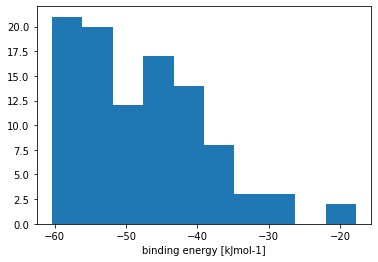

In [43]:
plt.hist([binding_energies_kjmol[i] for i in binding_energies_kjmol])
plt.xlabel('binding energy [kJmol-1]')
plt.show()